In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    print(f'Number of available CUDA devices: {num_devices}')
    
    for device_id in range(num_devices):
        device_name = torch.cuda.get_device_name(device_id)
        device_capability = torch.cuda.get_device_capability(device_id)
        print(f'Device {device_id}: {device_name}')
        print(f' - Compute Capability: {device_capability}')
        print(f' - Memory Allocated: {torch.cuda.memory_allocated(device_id)} bytes')
        print(f' - Memory Cached: {torch.cuda.memory_reserved(device_id)} bytes')
else:
    print('CUDA is not available on this system.')


Number of available CUDA devices: 1
Device 0: NVIDIA GeForce GTX 1650
 - Compute Capability: (7, 5)
 - Memory Allocated: 0 bytes
 - Memory Cached: 0 bytes


In [3]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class NpyDataset(Dataset):
    def __init__(self, input_dir, output_dir):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.input_files = sorted(os.listdir(input_dir))
        self.output_files = sorted(os.listdir(output_dir))

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        input_path = os.path.join(self.input_dir, self.input_files[idx])
        output_path = os.path.join(self.output_dir, self.output_files[idx])
        
        input_image = np.load(input_path).astype(np.float32)
        output_image = np.load(output_path).astype(np.float32)
        
        input_image = torch.from_numpy(input_image).permute(2, 0, 1)  # Change from (H, W, C) to (C, H, W)
        output_image = torch.from_numpy(output_image).unsqueeze(0)  # Add channel dimension

        return input_image, output_image


In [4]:
class NpyValidationDataset(Dataset):
    def __init__(self, input_dir, ground_truth_dir):
        self.input_dir = input_dir
        self.ground_truth_dir = ground_truth_dir
        self.input_files = sorted(os.listdir(input_dir))
        self.ground_truth_files = sorted(os.listdir(ground_truth_dir))

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        input_path = os.path.join(self.input_dir, self.input_files[idx])
        ground_truth_path = os.path.join(self.ground_truth_dir, self.ground_truth_files[idx])
        
        input_image = np.load(input_path).astype(np.float32)
        ground_truth_image = np.load(ground_truth_path).astype(np.float32)
        
        input_image = torch.from_numpy(input_image).permute(2, 0, 1)  # Change from (H, W, C) to (C, H, W)
        ground_truth_image = torch.from_numpy(ground_truth_image).unsqueeze(0)  # Add channel dimension

        return input_image, ground_truth_image


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        self.enc5 = self.conv_block(512, 1024)

        self.pool = nn.MaxPool2d(2)

        self.up1 = self.upconv(1024, 512)
        self.dec1 = self.conv_block(1024, 512)
        
        self.up2 = self.upconv(512, 256)
        self.dec2 = self.conv_block(512, 256)
        
        self.up3 = self.upconv(256, 128)
        self.dec3 = self.conv_block(256, 128)
        
        self.up4 = self.upconv(128, 64)
        self.dec4 = self.conv_block(128, 64)
        
        self.out_conv = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return block

    def upconv(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        enc5 = self.enc5(self.pool(enc4))

        dec1 = self.up1(enc5)
        dec1 = torch.cat((dec1, enc4), dim=1)
        dec1 = self.dec1(dec1)
        
        dec2 = self.up2(dec1)
        dec2 = torch.cat((dec2, enc3), dim=1)
        dec2 = self.dec2(dec2)
        
        dec3 = self.up3(dec2)
        dec3 = torch.cat((dec3, enc2), dim=1)
        dec3 = self.dec3(dec3)
        
        dec4 = self.up4(dec3)
        dec4 = torch.cat((dec4, enc1), dim=1)
        dec4 = self.dec4(dec4)
        
        out = self.out_conv(dec4)
        
        return out

# Instantiate the model
model = UNet()
print(model)

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc5): Sequential(
    (0): Conv2d(512, 1024, kernel_

In [6]:
import torch.optim as optim

def train_model(model, dataloader, criterion, optimizer, num_epochs=25):
    model.train()
    for epoch in range(num_epochs):
        print(f"{epoch}")
        running_loss = 0.0
        
        for inputs, labels in dataloader:
            print("good")
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}')
        
    print('Training complete')


In [7]:
import torch.optim as optim
import os

def train_model_without_dataloader(model, dataset, criterion, optimizer, num_epochs=25, batch_size=16, save_path='unet_dir_v3.pth'):
    model.train()
    
    best_loss = float('inf')
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i in range(0, len(dataset), batch_size):
            inputs_batch = []
            labels_batch = []
            for j in range(i, min(i + batch_size, len(dataset))):
                inputs, labels = dataset[j]
                inputs_batch.append(inputs)
                labels_batch.append(labels)

            inputs_batch = torch.stack(inputs_batch).to(device)
            labels_batch = torch.stack(labels_batch).to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs_batch.size(0)
        
        epoch_loss = running_loss / len(dataset)
        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}')
        
        # Save the model if the loss is the best we've seen so far
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), save_path)
            print(f'New best model saved with loss {best_loss:.4f}')

        print(f'GPU Memory Allocated: {torch.cuda.memory_allocated(device)} bytes')
        print(f'GPU Memory Cached: {torch.cuda.memory_reserved(device)} bytes')
        
    print('Training complete')


In [27]:
import torch.nn as nn

# Parameters
input_dir = 'Training_data/Input_data'
output_dir = 'Training_data/Output_data'
batch_size = 16
num_epochs = 20
learning_rate = 1e-5

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Dataset
dataset = NpyDataset(input_dir, output_dir)

# Model
model = UNet().to(device)

# Load the pre-trained model weights if available
model.load_state_dict(torch.load('unet_dir_L2_aug.pth', map_location=device))

# Loss and Optimizer
criterion = nn.MSELoss()
# criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Print dataset length
print(f'The length of the dataset is: {len(dataset)}')

# Train the model
train_model_without_dataloader(model, dataset, criterion, optimizer, num_epochs, batch_size, save_path='unet_dir_L2_aug_2.pth')


The length of the dataset is: 191040
Epoch 0/19, Loss: 319.6206
New best model saved with loss 319.6206
GPU Memory Allocated: 1273733120 bytes
GPU Memory Cached: 3856662528 bytes


KeyboardInterrupt: 

In [6]:
# Check if CUDA is available and set the device accordingly
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Ensure the correct device is being used
if device.type == 'cuda':
    print(f'CUDA device name: {torch.cuda.get_device_name(0)}')

# Parameters
input_dir = 'Training_data/Input_data'
output_dir = 'Training_data/Output_data'
validation_input_dir = 'Validation_data/Input_data'
validation_gt_dir = 'Validation_data/GT'

batch_size = 32
num_epochs = 30
learning_rate = 1e-4
model_save_path = 'Unet_Dir0030_v2.pth'

# Dataset and DataLoader
dataset = NpyDataset(input_dir, output_dir)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


#Validation Dataset and Dataloader
validation_dataset = NpyValidationDataset(validation_input_dir, validation_gt_dir)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False) 


# Model
model = UNet().to(device)

# Loss and Optimizer
criterion = nn.MSELoss()
# criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Learning Rate Scheduler
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)  # Reduce LR by a factor of 0.1 every 10 epochs

# ReduceLROnPlateau scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Print dataset length
print(f'The length of training dataset is: {len(dataset)}')
print(f'The length of validation dataset is: {len(validation_dataset)}')

# Training Loop
best_loss = float('inf')
training_loss = []
validation_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(dataset)
    training_loss.append(epoch_loss)
    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}')

   
    # Validation Loop
    model.eval()
    validation_running_loss = 0.0
    
    with torch.no_grad():
        for val_inputs, val_labels in validation_dataloader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            
            validation_running_loss += val_loss.item() * val_inputs.size(0)
    
    validation_epoch_loss = validation_running_loss / len(validation_dataset)
    validation_losses.append(validation_epoch_loss)  # Save the validation loss value
    print(f'Epoch {epoch}/{num_epochs - 1}, Validation Loss: {validation_epoch_loss:.4f}')
    

    # Step the learning rate scheduler
    scheduler.step(epoch_loss)

    for param_group in optimizer.param_groups:
        current_lr = param_group['lr']
        print(f'Learning Rate after Epoch {epoch}: {current_lr:.8f}')
    
    # Save the model if the validation loss is the best we've seen so far
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), model_save_path)
        print(f'New best model saved with loss {best_loss:.4f}')


print('Training complete')

"""
# Plot loss curve
plt.figure()
plt.plot(range(num_epochs), training_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()
"""

# Create a figure
plt.figure(figsize=(12, 6))

# Subplot 1: Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), training_loss, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()


# Subplot 2: Validation Loss
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), validation_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Curve')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


Using device: cuda:0
CUDA device name: NVIDIA GeForce GTX 1650


c:\Users\User\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


The length of training dataset is: 205920
The length of validation dataset is: 29520
Epoch 0/29, Loss: 148.0566
Epoch 0/29, Validation Loss: 361.1448
Learning Rate after Epoch 0: 0.00010000
New best model saved with loss 148.0566
Epoch 1/29, Loss: 145.7251
Epoch 1/29, Validation Loss: 360.2407
Learning Rate after Epoch 1: 0.00010000
New best model saved with loss 145.7251


KeyboardInterrupt: 

In [10]:
torch.save(model.state_dict(), model_save_path)

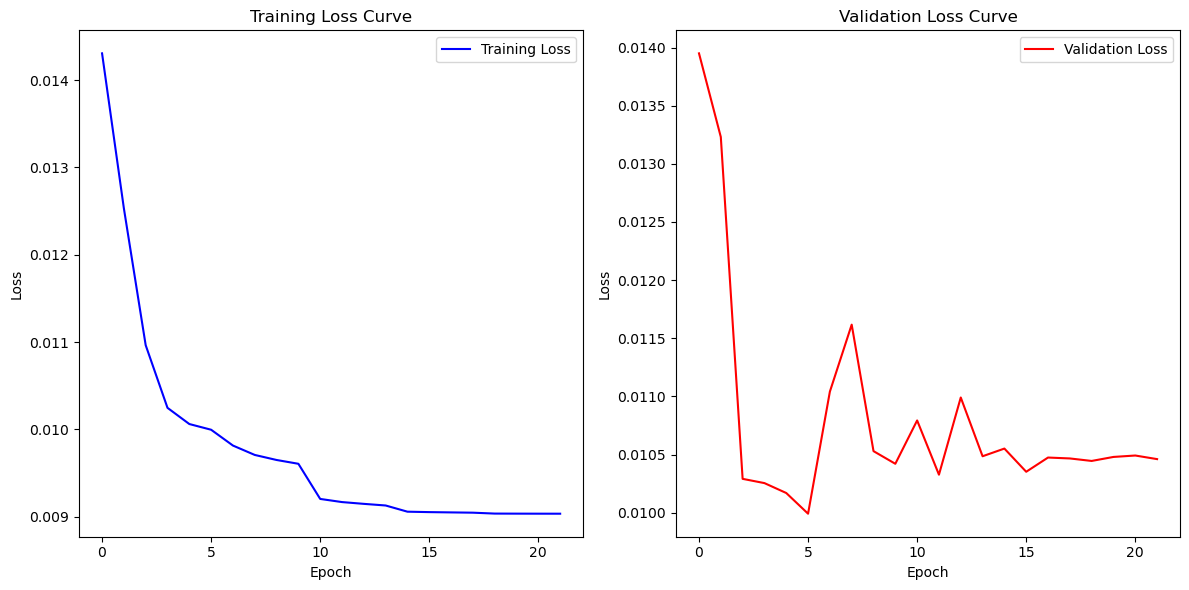

In [8]:
# Create a figure
plt.figure(figsize=(12, 6))

# Subplot 1: Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(0, 22), training_loss, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()


# Subplot 2: Validation Loss
plt.subplot(1, 2, 2)
plt.plot(range(0, 22), validation_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Curve')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = UNet().to(device)
model.load_state_dict(torch.load('Unet_Dir0030.pth'))
model.eval()  # Set the model to evaluation mode

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc5): Sequential(
    (0): Conv2d(512, 1024, kernel_

In [20]:
# Load an input sample
input_path = 'Validation_data/Input_data/PGmap3_650_1.npy'
input_image = np.load(input_path).astype(np.float32)
sparse = input_image[:, :, 2]

"""
input_image[:, :, 0] = (input_image[:, :, 0] + 160) / 160.0
        
# Second channel: Normalize {0, 255} to [0, 1]
input_image[:, :, 1] = input_image[:, :, 1] / 255.0
        
# Third channel: Normalize (-160, 35) to [0, 1]
input_image[:, :, 2] = (input_image[:, :, 2] + 160) / 195.0
"""
input_image = torch.from_numpy(input_image).permute(2, 0, 1).unsqueeze(0)  # Shape: (1, 3, 128, 128)

# Move to the device
input_image = input_image.to(device)

sample points = 32


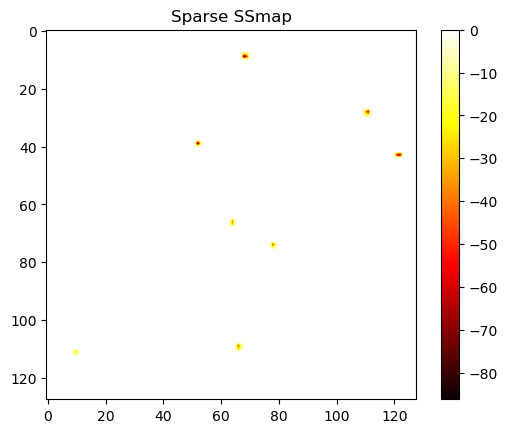

In [22]:
sample_points = 0
for i in sparse:
    for j in i:
        if j != 0:
            sample_points += 1

print(f"sample points = {sample_points}")
plt.imshow(sparse, cmap='hot', interpolation='bilinear')
plt.colorbar()
plt.title('Sparse SSmap')
plt.show()

In [11]:
# Run the model to get the prediction
with torch.no_grad():
    output = model(input_image)

# output = 195.0*output - 160

# Process the output
output = output.squeeze().cpu().numpy()  # Remove batch dimension and move to CPU


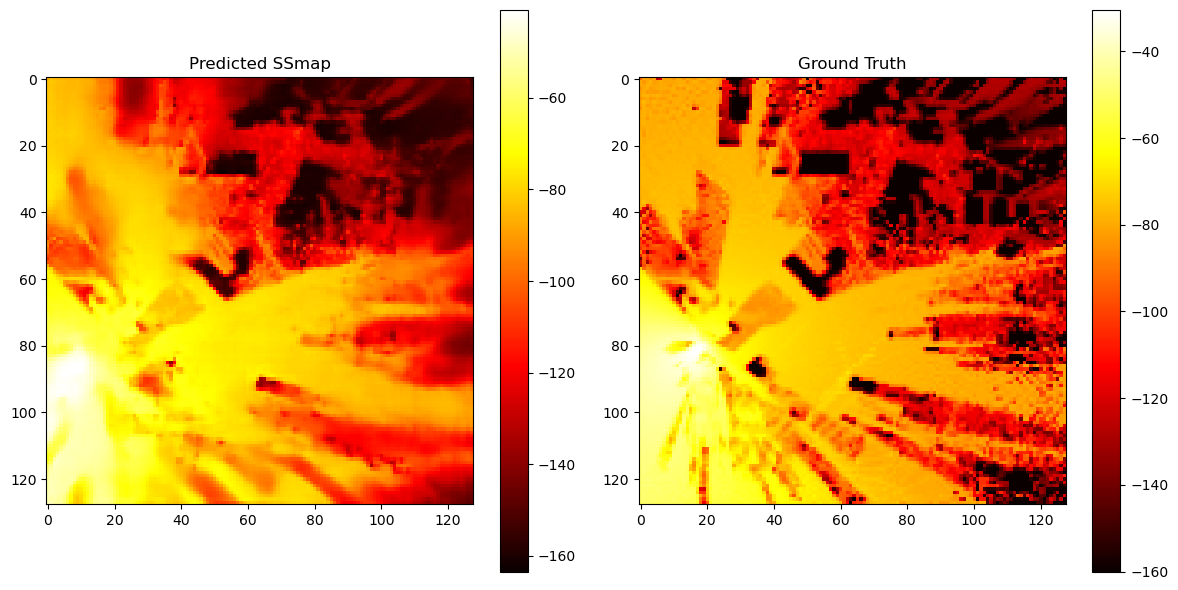

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 載入兩個 .npy 檔案
GT = np.load('Validation_data/GT/SSmap3_650_1.npy')

# 創建一個包含兩個子圖的圖形
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# 顯示第一張圖
im0 = axs[0].imshow(output, cmap='hot')
axs[0].set_title('Predicted SSmap')
fig.colorbar(im0, ax=axs[0])  # 为第一张图添加 colorbar

# 顯示第二張圖
im1 = axs[1].imshow(GT, cmap='hot')
axs[1].set_title('Ground Truth')
fig.colorbar(im1, ax=axs[1])  # 为第二张图添加 colorbar

# 顯示圖形
plt.tight_layout()  # 自動調整子圖之間的間距
plt.show()


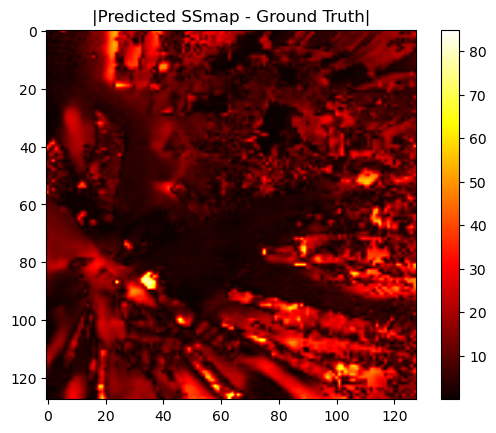

In [15]:
res = abs(output - GT)

plt.imshow(res, cmap='hot', interpolation='bilinear')
plt.colorbar()
plt.title('|Predicted SSmap - Ground Truth|')
plt.show()

The length of validation dataset is: 29520
start plotting


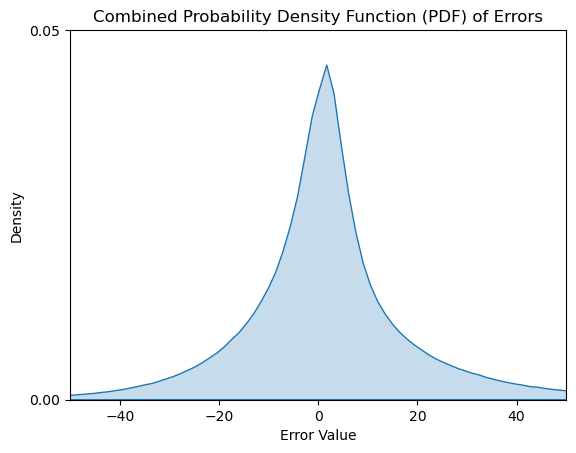

In [8]:
import os
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Custom dataset class to load input and ground truth pairs
class InputGroundTruthDataset(Dataset):
    def __init__(self, input_dir, gt_dir):
        self.input_dir = input_dir
        self.gt_dir = gt_dir
        self.input_files = sorted(os.listdir(input_dir))
        self.gt_files = sorted(os.listdir(gt_dir))

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        input_path = os.path.join(self.input_dir, self.input_files[idx])
        gt_path = os.path.join(self.gt_dir, self.gt_files[idx])
        
        input_image = np.load(input_path).astype(np.float32)
        gt_image = np.load(gt_path).astype(np.float32)

        input_image = torch.from_numpy(input_image).permute(2, 0, 1)  # Convert to (C, H, W)
        gt_image = torch.from_numpy(gt_image).unsqueeze(0)  # Add channel dimension if needed
        
        return input_image, gt_image

# Directories for input and ground truth
input_dir = 'Validation_data/Input_data'
gt_dir = 'Validation_data/GT'

# Create dataset and dataloader without specifying batch size
dataset = InputGroundTruthDataset(input_dir, gt_dir)
dataloader = DataLoader(dataset, shuffle=True)  # No batch size specified
print(f'The length of validation dataset is: {len(dataset)}')

# Define MAE loss function
mae_criterion = nn.L1Loss()

# Load the trained model
model = UNet().to(device)
model.load_state_dict(torch.load('Unet_Dir0030.pth', map_location=device))

# Model evaluation
model.eval()

total_mae = 0.0
num_samples = len(dataloader)
error_matrices = []
a = 0
with torch.no_grad():
    for inputs, gt in dataloader:
        inputs, gt = inputs.to(device), gt.to(device)
        
        # Make predictions
        outputs = model(inputs)
        
        res = outputs - gt
        error_matrices.append(res)
        a += 1
        
        if a > 500:
            break
        # Optionally print or save outputs for inspection
        # print(f"MAE: {mae.item()}")
all_errors = np.concatenate([matrix.cpu().flatten() for matrix in error_matrices])

print("start plotting")
sns.kdeplot(all_errors, bw_adjust=0.5, fill=True)

# 设置标题和标签
plt.title("Combined Probability Density Function (PDF) of Errors")
plt.xlabel("Error Value")
plt.ylabel("Density")
plt.xticks([-40, -20, 0, 20, 40])
plt.yticks([0, 0.05])
plt.xlim(-50, 50)

# 显示图像
plt.show()


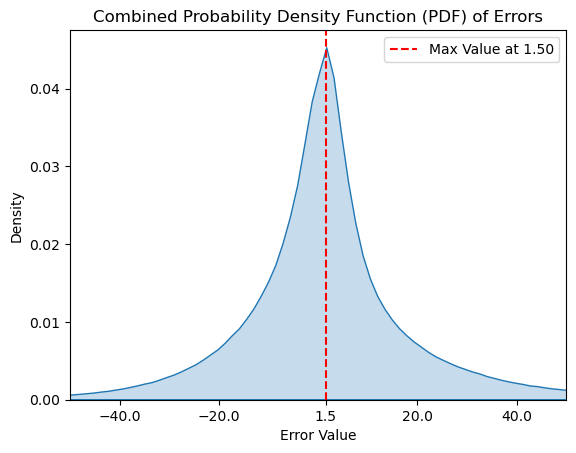

In [11]:
sns.kdeplot(all_errors, bw_adjust=0.5, fill=True)

# 设置标题和标签
plt.title("Combined Probability Density Function (PDF) of Errors")
plt.xlabel("Error Value")
plt.ylabel("Density")
plt.xticks([-40, -20, 20, 40])
# plt.yticks([0, 0.05])
plt.xlim(-50, 50)

# 找到最大值的位置
density, x = np.histogram(all_errors, bins=100, density=True)
x = (x[:-1] + x[1:]) / 2  # 計算每個區間的中心
max_density_idx = np.argmax(density)
max_x = x[max_density_idx]
max_x = 1.5


# 在橫軸上標記最大值的位置並繪製垂直線
plt.axvline(max_x, color='red', linestyle='--', label=f'Max Value at {max_x:.2f}')
plt.legend()

# 在橫軸上添加最大值的位置
xticks = list(plt.xticks()[0])  # 獲取當前的刻度
xticks.append(max_x)  # 添加最大值的位置
xticks = sorted(set(xticks))  # 排序以保持刻度有序，並去除重複值
plt.xticks(xticks)  # 設置新的刻度

# 顯示圖像
plt.show()

# 显示图像
plt.show()

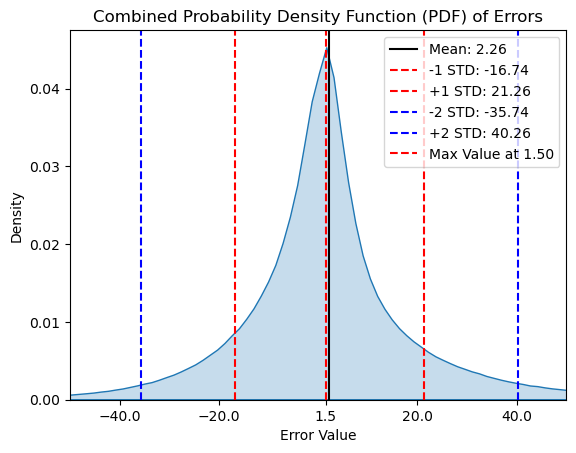

In [12]:
mean_error = np.mean(all_errors)
std_dev = np.std(all_errors)

sns.kdeplot(all_errors, bw_adjust=0.5, fill=True)

# 绘制信赖区间
plt.axvline(mean_error, color='k', linestyle='-', label=f'Mean: {mean_error:.2f}')
plt.axvline(mean_error - std_dev, color='red', linestyle='--', label=f'-1 STD: {mean_error - std_dev:.2f}')
plt.axvline(mean_error + std_dev, color='red', linestyle='--', label=f'+1 STD: {mean_error + std_dev:.2f}')
plt.axvline(mean_error - 2 * std_dev, color='blue', linestyle='--', label=f'-2 STD: {mean_error - 2 * std_dev:.2f}')
plt.axvline(mean_error + 2 * std_dev, color='blue', linestyle='--', label=f'+2 STD: {mean_error + 2 * std_dev:.2f}')

# 设置标题和标签
plt.title("Combined Probability Density Function (PDF) of Errors")
plt.xlabel("Error Value")
plt.ylabel("Density")
plt.xticks([-40, -20, 20, 40])
# plt.yticks([0, 0.05])
plt.xlim(-50, 50)

# 找到最大值的位置
density, x = np.histogram(all_errors, bins=100, density=True)
x = (x[:-1] + x[1:]) / 2  # 計算每個區間的中心
max_density_idx = np.argmax(density)
max_x = x[max_density_idx]
max_x = 1.5


# 在橫軸上標記最大值的位置並繪製垂直線
plt.axvline(max_x, color='red', linestyle='--', label=f'Max Value at {max_x:.2f}')
plt.legend()

# 在橫軸上添加最大值的位置
xticks = list(plt.xticks()[0])  # 獲取當前的刻度
xticks.append(max_x)  # 添加最大值的位置
xticks = sorted(set(xticks))  # 排序以保持刻度有序，並去除重複值
plt.xticks(xticks)  # 設置新的刻度

# 顯示圖像
plt.show()

# 显示图像
plt.show()

In [9]:
# all_errors = np.concatenate([matrix.cpu().flatten() for matrix in error_matrices])
print(len(all))
sample_size = len(all_errors) // 2  # 取一半大小
sampled_errors = np.random.choice(all_errors, size=sample_size, replace=False)

print("start plotting")
sns.kdeplot(all_errors, bw_adjust=0.5, fill=True)

# 设置标题和标签
plt.title("Combined Probability Density Function (PDF) of Errors")
plt.xlabel("Error Value")
plt.ylabel("Density")

# 显示图像
plt.show()

: 

: 

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, dataset, criterion, batch_size=16):
    model.eval()  # Set the model to evaluation mode
    
    running_loss = 0.0
    
    with torch.no_grad():  # Disable gradient calculation
        for i in range(0, len(dataset), batch_size):
        # for i in range(7440, 36960, batch_size):
            inputs_batch = []
            labels_batch = []
            for j in range(i, min(i + batch_size, len(dataset))):
                inputs, labels = dataset[j]
                inputs_batch.append(inputs)
                labels_batch.append(labels)

            inputs_batch = torch.stack(inputs_batch).to(device)
            labels_batch = torch.stack(labels_batch).to(device)
            
            outputs = model(inputs_batch)
           
            loss = criterion(outputs, labels_batch)
            
            running_loss += loss.item() * inputs_batch.size(0)
    
    epoch_loss = running_loss / len(dataset)
    # epoch_loss = running_loss / 29520
    print(f'Validation Loss : {epoch_loss:.4f}')
    return epoch_loss

# Parameters
validation_input_dir = 'Validation_data/Input_data'
validation_ground_truth_dir = 'Validation_data/GT'
batch_size = 16

# Validation Dataset
validation_dataset = NpyValidationDataset(validation_input_dir, validation_ground_truth_dir)
print(f'The length of validation dataset is: {len(validation_dataset)}')

# Load the trained model
model = UNet().to(device)
model.load_state_dict(torch.load('Unet_Dir0030_wd5n.pth', map_location=device))

# Loss function
criterion = nn.L1Loss()

# Evaluate the model
validation_loss = evaluate_model(model, validation_dataset, criterion, batch_size)



The length of validation dataset is: 29520


UnboundLocalError: cannot access local variable 'output' where it is not associated with a value